<a href="https://colab.research.google.com/github/gmb408/OSSP-KBO-prediction/blob/version-0.1/Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# 데이터 분석 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

In [1]:
# 출력 할 때 마다, 기존 출력물들은 제거해주는 모듈
from IPython.display import clear_output

In [2]:
# 모델 모듈
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [9]:
submission = pd.read_csv("/content/submission.csv")
result = pd.read_csv("/content/statiz_v2.csv", index_col=0)
reg = pd.read_csv("/content/Regular_Season_Batter.csv")


In [10]:
# 사용 features 명시
infos = ['ID','이름','생일','팀','시즌','포지션','나이']
stats = ['G','타수','득점','안타','1타','2타','3타','홈런','루타','타점','도루','도실','볼넷','사구','고4','삼진'\
        ,'병살','희타','희비','타율','출루','장타','OPS']

In [11]:
# 누적 및 lag stat features 이름
stats_cum = [i + '_누적' for i in stats]
stats_lag1 = [i + '_LAG1' for i in stats]
stats_lag2 = [i + '_LAG2' for i in stats]
stats_lag3 = [i + '_LAG3' for i in stats]

In [28]:
# X features와 y feature 정리
stats_position = ['2B', '3B', 'C', 'CF', 'DH', 'LF', 'RF', 'SS']
X_cols = stats + stats_cum + stats_lag1 + stats_lag2 + stats_position + ['나이'] 
y_cols = ['OPS_NEXT']
z_cols = stats + stats_cum + stats_lag1 + stats_lag2

resultdf = pd.DataFrame(data=result,columns=z_cols)
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(resultdf)
results = scaler.transform(resultdf)
irisDF_scaled = pd.DataFrame(results,columns=z_cols)
result[z_cols] = irisDF_scaled[z_cols]


In [29]:
df = result.fillna(-1) # nan값 -1로 impute 
df = df[df['OPS_NEXT'] > 0] # 다음 해의 OPS가 존재하는 값들만 추출 (다음 해 OPS 가 없다면, predict 값과 target값을 비교 할 수 없기 때문)
df = pd.concat([df, pd.get_dummies(df['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환
df


,ID,이름,생일,팀,시즌,포지션,나이,G,타석,타수,...,OPS_NEXT,1B,2B,3B,C,CF,DH,LF,RF,SS
0,0,이종범,1970-08-15,해,1994,SS,25,0.850746,561.0,0.824653,...,0.983,0,0,0,0,0,0,0,0,1
1,1,테임즈,1986-11-10,N,2015,1B,30,0.985075,595.0,0.777778,...,1.106,1,0,0,0,0,0,0,0,0
2,2,심정수,1975-05-05,현,2003,RF,29,0.917910,601.0,0.756944,...,0.864,0,0,0,0,0,0,0,1,0
4,0,이종범,1970-08-15,해,1996,SS,27,0.768657,525.0,0.737847,...,1.009,0,0,0,0,0,0,0,0,1
5,3,이승엽,1976-08-18,삼,2002,1B,27,0.917910,617.0,0.845486,...,1.127,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2765,430,김동엽,1990-07-24,S,2016,DH,27,0.350746,150.0,0.206597,...,0.826,0,0,0,0,0,1,0,0,0
2766,183,김민성,1988-12-17,넥,2011,2B,24,0.850746,373.0,0.503472,...,0.725,0,1,0,0,0,0,0,0,0
2767,634,최원준,1997-03-23,K,2017,3B,21,0.462687,174.0,0.229167,...,0.688,0,0,1,0,0,0,0,0,0
2768,190,조동찬,1983-07-27,삼,2011,3B,29,0.559701,235.0,0.319444,...,0.785,0,0,1,0,0,0,0,0,0


In [30]:
# 학습시킬 모델
from sklearn.ensemble import GradientBoostingRegressor
model_dict = {'xgb':XGBRegressor(n_estimators=110, learning_rate=0.05 ,max_depth=3, min_samples_split=400, random_state=23),
              'lgbm':LGBMRegressor(random_state=23),
              'rf':RandomForestRegressor(),
              'svr':SVR(),
              'knn':KNeighborsRegressor(),
              'reg':LinearRegression(),
              'ridge':Ridge(),
              'gbm' : GradientBoostingRegressor(random_state=23)
              }


In [31]:
# 2009 ~ 2016년 기간의 데이터로 검증
# 예를들어 2010년은 2009년까지의 데이터로, 2011년은 2010년까지의 데이터로 검증
# 에러가 가장 낮은 두 모델, xgboost와 ridge 중 ridge 선택
# ridge가 xgboost에 비해 과적합이 적고 일반화가 더 잘 이뤄졌을 것이라는 판단

test_error = []
r2 = []

for year in range(2010, 2018):

    train = df[df['시즌'] < year-1].reset_index(drop=True)
    test = df[df['시즌'] == year-1].reset_index(drop=True)
    
    X_train = train[X_cols]
    y_train = train[y_cols]

    X_test = test[X_cols]
    y_test = test[y_cols]
    
    model = model_dict['xgb']    #모델명 바꾸어 가면서 실험 가능
    model2 = model_dict['lgbm'] 
    model3 = model_dict['gbm']

    
    model.fit( X_train, y_train )
    model2.fit(X_train, y_train )
    model3.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    y_predict2 = model2.predict(X_test)
    y_predict3 = model3.predict(X_test)
    fin =  (y_predict *0.6) +  (y_predict2*0.2) +  (y_predict3*0.2)
    test_error.append(mean_squared_error(y_test,  fin,) ** 0.5)
    r2.append(r2_score(y_test, fin))

    clear_output(wait=True)
    print(year, ": 완료")
    
print("test error : ", np.mean(test_error))
print("RMSE : ", np.std(test_error))
print("r2 : ", np.mean(r2))
print("완료")

2017 : 완료
test error :  0.10725908388697449
RMSE :  0.014989766983428977
r2 :  0.2790979751916314
완료


In [33]:
# 연도별 테스트 에러
test_error

[0.09687124203174646,
 0.0903757457107135,
 0.099542225498822,
 0.09616697982052667,
 0.14002335845044545,
 0.11941738389248864,
 0.10792136310617992,
 0.10775437258487328]

(0.0, 1.5)

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text

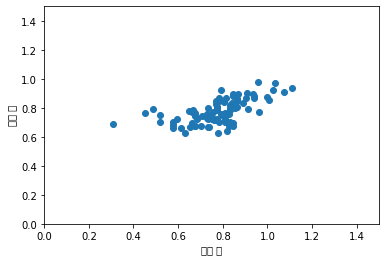

In [34]:
# 예측값과 실제값의 시각화
plt.scatter(y_test, y_predict)
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.xlim(0,1.5)
plt.ylim(0,1.5)

In [35]:
predict = result[result['시즌']==2018] # 2018년도 데이터 프레임
predict = pd.concat([predict, pd.get_dummies(predict['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환

In [36]:
# Dacon regular season과 submission 병합
# 추후 statiz data와 병합할 때 기준이 되는 생일 데이터를 얻기 위함
reg_sub = pd.merge(submission, reg[reg['year']==2018], on='batter_id', how='left', suffixes=['','_reg'])

In [37]:

# regular season dataframe의 생일 데이터를 statiz와 일치시킴
reg_sub['year_born'] = reg_sub['year_born'].apply(lambda x: datetime.strptime(x, "%Y년 %m월 %d일").date())
reg_sub['year_born'] = reg_sub['year_born'].astype(str)

In [38]:
# 필요한 feature만 남김
reg_sub = reg_sub[['batter_name', 'year_born', 'batter_id']]

In [39]:
# 이름과 생일을 기준으로 dacon data와 statiz data 병합
total = pd.merge(reg_sub, predict, how='left', left_on=['batter_name', 'year_born'], right_on=['이름', '생일'])


In [40]:
X = total[X_cols] # 사용 feature
X = X.fillna(-1) # NA값 -1로 impute

In [41]:
# 예측
total['y_hat'] = model.predict(X)
total['dddd'] = model.predict(X)

In [42]:
# 타자별 예측값 feature에 저장
submission['batter_ops'] = submission['batter_id'].apply(lambda x: total[total['batter_id']==x]['y_hat'].values[0])

In [43]:
# 제출 파일 생성
submission.to_csv("/content/tnt_submission.csv", index=False, encoding='utf-8')

In [44]:

# 제출 결과 확인
sub = pd.read_csv('/content/tnt_submission.csv')
sub

,batter_id,batter_name,batter_ops
0,1,강경학,0.678592
1,2,강구성,0.575504
2,3,강민국,0.575504
3,4,강민호,0.817305
4,5,강백호,0.840986
...,...,...,...
215,337,홍재호,0.575504
216,338,홍창기,0.575504
217,341,황윤호,0.575504
218,342,황재균,0.814033
